[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alanjeffares/TANGOS/blob/main/TANGOS_quickstart.ipynb)

# TANGOS quickstart guide
This script provides a simple example of applying TANGOS as a drop in regularizer in a standard pytorch workflow. We begin by defining a dataloader and a simple MLP architecture before providing a straightforward function for calculating the two TANGOS loss terms - specialization loss and orthogonalization loss. We then provide an example of this loss being applied to train a model in a standard training loop.

In [20]:
import random
from functorch import jacrev
from functorch import vmap
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

## First define a simple data loader 

In [21]:
# a data loader for the data
def load_bioconcentration(seed, train_prop=0.8, batch_size=64):
    """Returns dataloaders for dummy data in the shape of the bioconcentration dataset"""
    # data = pd.read_csv("../Grisoni_et_al_2016_EnvInt88.csv", sep=",")
    data = pd.DataFrame(data={
        "nHM": [random.choice([0,1,2,3,4,5,6,7,8,10,12]) for i in range(779)],
        "piPC09": [random.uniform(0,9.3) for i in range(779)],
        "PCD": [random.uniform(0,5.9) for i in range(779)],
        "X2Av": [random.uniform(0,2.3) for i in range(779)],
        "MLOGP": [random.uniform(-2,8.3) for i in range(779)],
        "ON1V": [random.uniform(0,7.2) for i in range(779)],
        "N-072": [random.choice([0,1,2,3]) for i in range(779)],
        "B02[C-N]": [random.choice([0,1]) for i in range(779)],
        "F04[C-O]": [random.choice([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,25]) for i in range(779)],
        "logBCF": [random.uniform(-2,6.1) for i in range(779)],
    })

    # apply onehotencoding where appropriate
    X = data[
        [
            "nHM",
            "piPC09",
            "PCD",
            "X2Av",
            "MLOGP",
            "ON1V",
            "N-072",
            "B02[C-N]",
            "F04[C-O]",
        ]
    ]

    for var in ["nHM", "N-072", "B02[C-N]", "F04[C-O]"]:
        one_hot = pd.get_dummies(X[var], prefix=var)  # onehotencode categorical columns
        X = X.drop(var, axis=1)
        X = X.join(one_hot)

    y = data["logBCF"]
    X, y = X.to_numpy(), y.to_numpy()

    # split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_prop, random_state=seed
    )

    # rescale data
    X_scaler = StandardScaler()
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
    y_test = y_scaler.transform(y_test.reshape(-1, 1)).reshape(-1)

    train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

    loaders = {
        "train": DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, num_workers=1
        ),
        "test": DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, num_workers=1
        ),
    }
    return loaders

# Next design a simple MLP architecture

In [22]:
class SimpleMLP(nn.Module):
    def __init__(self, num_features):
        super(SimpleMLP, self).__init__()
        d = num_features + 1
        num_outputs = 1
        self.fc1 = nn.Linear(num_features, d)
        self.bn1 = nn.BatchNorm1d(d)
        self.relu1 = nn.ReLU(inplace=False)
        self.fc2 = nn.Linear(d, d)
        self.bn2 = nn.BatchNorm1d(d)
        self.relu2 = nn.ReLU(inplace=False)
        self.fc3 = nn.Linear(d, num_outputs)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        h_output = self.relu2(out)
        out = self.fc3(h_output)
        return (
            out,
            h_output,
        )  # note that we ensure the model outputs both predictions and a latent representation

# Finally, we define a drop in function that calculates the TANGOS loss - outputting both the specialization and the orthogonalization components.

In [23]:
def TANGOS_loss(
    forward_func: Callable,
    data_input: torch.tensor,
    subsample: int = 50,
    device: str = "cpu",
):
    """
    A drop in function for calculating the TANGOS regularization loss. The loss
    consists of two components (specialization and orthogonalization) which are
    described in more detail in the main paper.

    Args:
        forward_func (Callable): The forward function from a pytorch model with
            an output tuple consisting of (_, latent_representation).
        data_input (torch.tensor): A batch of data.
        subsample (int): Number of pairs to subsample for the orthogonalization
            component.
        device (str): Indicating what device to run on.

    Returns:
        tuple containing the specialization loss and the orthogonalization loss
            both in torch tensor format.
    """

    batch_size = data_input.shape[0]

    def wrapper(input_):
        """A simple wrapper required by functools"""
        _, h_out = forward_func(input_)
        return h_out

    data_input = data_input.clone().requires_grad_(True)
    jacobian = vmap(jacrev(wrapper))(data_input)
    neuron_attr = jacobian.swapaxes(0, 1)
    h_dim = neuron_attr.shape[0]

    if len(neuron_attr.shape) > 3:
        # h_dim x batch_size x features
        neuron_attr = neuron_attr.flatten(start_dim=2)

    # calculate specialization loss component
    spec_loss = torch.norm(neuron_attr, p=1) / (
        batch_size * h_dim * neuron_attr.shape[2]
    )

    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    orth_loss = torch.tensor(0.0, requires_grad=True).to(device)

    # apply subsampling routine for orthogonalization loss
    if subsample > 0 and subsample < h_dim * (h_dim - 1) / 2:
        tensor_pairs = [
            list(np.random.choice(h_dim, size=(2), replace=False))
            for i in range(subsample)
        ]
        for tensor_pair in tensor_pairs:
            pairwise_corr = cos(
                neuron_attr[tensor_pair[0], :, :], neuron_attr[tensor_pair[1], :, :]
            ).norm(p=1)
            orth_loss = orth_loss + pairwise_corr

        orth_loss = orth_loss / (batch_size * subsample)

    else:
        for neuron_i in range(1, h_dim):
            for neuron_j in range(0, neuron_i):
                pairwise_corr = cos(
                    neuron_attr[neuron_i, :, :], neuron_attr[neuron_j, :, :]
                ).norm(p=1)
                orth_loss = orth_loss + pairwise_corr
        num_pairs = h_dim * (h_dim - 1) / 2
        orth_loss = orth_loss / (batch_size * num_pairs)

    return spec_loss, orth_loss

# Train a model with TANGOS regularization and another with L2 regularization. 

In [24]:
# set seed for reproducablility
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

loss_func = nn.MSELoss()
data = load_bioconcentration(0)
train_loader = data["train"]
val_loader = data["test"]

lambda_1, lambda_2 = 100, 0.1
lr = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_epochs = 100

# instantiate models and optimimizers
TANGOS_model = SimpleMLP(num_features=45).to(device)
L2_model = SimpleMLP(num_features=45).to(device)
TANGOS_optimiser = optim.Adam(TANGOS_model.parameters(), lr=lr, weight_decay=0)
L2_optimiser = optim.Adam(L2_model.parameters(), lr=lr, weight_decay=0.1)

TANGOS_train_loss_ls = []
L2_train_loss_ls = []
TANGOS_val_loss_ls = []
L2_val_loss_ls = []

for epoch in range(n_epochs):
    TANGOS_running_loss = 0
    L2_running_loss = 0
    # training epoch
    for data, label in train_loader:
        TANGOS_model.train()
        L2_model.train()
        data, label = data.to(device), label.to(device)
        TANGOS_optimiser.zero_grad()
        L2_optimiser.zero_grad()

        # forward and backward pass for TANGOS model
        TANGOS_output, _ = TANGOS_model(data)
        MSE_loss = loss_func(TANGOS_output.squeeze(), label)

        spec_loss, orth_loss = TANGOS_loss(
            TANGOS_model, data, subsample=50, device=device
        )  # calculate TANGOS loss
        TANGOS_reg_loss = (
            lambda_1 * spec_loss + lambda_2 * orth_loss
        )  # weight the two terms
        TANGOS_loss_val = MSE_loss + TANGOS_reg_loss  # add TANGOS loss to MSE loss

        TANGOS_running_loss += MSE_loss.item()
        TANGOS_loss_val.backward()
        TANGOS_optimiser.step()

        # forward and backward pass for L2 model
        L2_output, _ = L2_model(data)
        MSE_loss = loss_func(L2_output.squeeze(), label)

        L2_running_loss += MSE_loss.item()
        MSE_loss.backward()
        L2_optimiser.step()

    TANGOS_train_loss_ls.append(TANGOS_running_loss)
    L2_train_loss_ls.append(L2_running_loss)

    TANGOS_running_val_loss = 0
    L2_running_val_loss = 0
    # validation epoch
    for data, label in val_loader:
        TANGOS_model.eval()
        L2_model.eval()
        data, label = data.to(device), label.to(device)

        # evaluate TANGOS model
        TANGOS_output, _ = TANGOS_model(data)
        TANGOS_reg_loss = loss_func(TANGOS_output.squeeze(), label)
        TANGOS_running_val_loss += TANGOS_reg_loss.item()

        # evaluate l2 model
        L2_output, _ = L2_model(data)
        L2_loss = loss_func(L2_output.squeeze(), label)
        L2_running_val_loss += L2_loss.item()

    TANGOS_val_loss_ls.append(TANGOS_running_val_loss)
    L2_val_loss_ls.append(L2_running_val_loss)

Index(['piPC09', 'PCD', 'X2Av', 'MLOGP', 'ON1V', 'nHM_0', 'nHM_1', 'nHM_2',
       'nHM_3', 'nHM_4', 'nHM_5', 'nHM_6', 'nHM_7', 'nHM_8', 'nHM_10',
       'nHM_12', 'N-072_0', 'N-072_1', 'N-072_2', 'N-072_3', 'B02[C-N]_0',
       'B02[C-N]_1', 'F04[C-O]_0', 'F04[C-O]_1', 'F04[C-O]_2', 'F04[C-O]_3',
       'F04[C-O]_4', 'F04[C-O]_5', 'F04[C-O]_6', 'F04[C-O]_7', 'F04[C-O]_8',
       'F04[C-O]_9', 'F04[C-O]_10', 'F04[C-O]_11', 'F04[C-O]_12',
       'F04[C-O]_13', 'F04[C-O]_14', 'F04[C-O]_15', 'F04[C-O]_16',
       'F04[C-O]_17', 'F04[C-O]_18', 'F04[C-O]_19', 'F04[C-O]_20',
       'F04[C-O]_21', 'F04[C-O]_25'],
      dtype='object')

,piPC09,PCD,X2Av,MLOGP,ON1V,nHM_0,nHM_1,nHM_2,nHM_3,nHM_4,...,F04[C-O]_13,F04[C-O]_14,F04[C-O]_15,F04[C-O]_16,F04[C-O]_17,F04[C-O]_18,F04[C-O]_19,F04[C-O]_20,F04[C-O]_21,F04[C-O]_25
0,4.493733,2.436345,1.311822,6.715121,1.907051,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6.127884,0.948726,0.055303,1.492263,3.555818,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,5.484965,4.847145,0.105253,5.836848,3.230737,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.826660,5.700875,0.033018,0.232473,2.020807,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.123866,0.557745,0.747719,0.438255,5.950783,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,5.313837,5.277844,0.953641,7.325236,6.051237,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
775,4.348154,1.995831,2.067470,6.209334,0.412302,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
776,0.602509,3.117726,1.494661,4.275888,3.656930,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
777,1.913776,0.977918,1.762196,3.706897,0.060231,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# Plot the training and validation loss plots

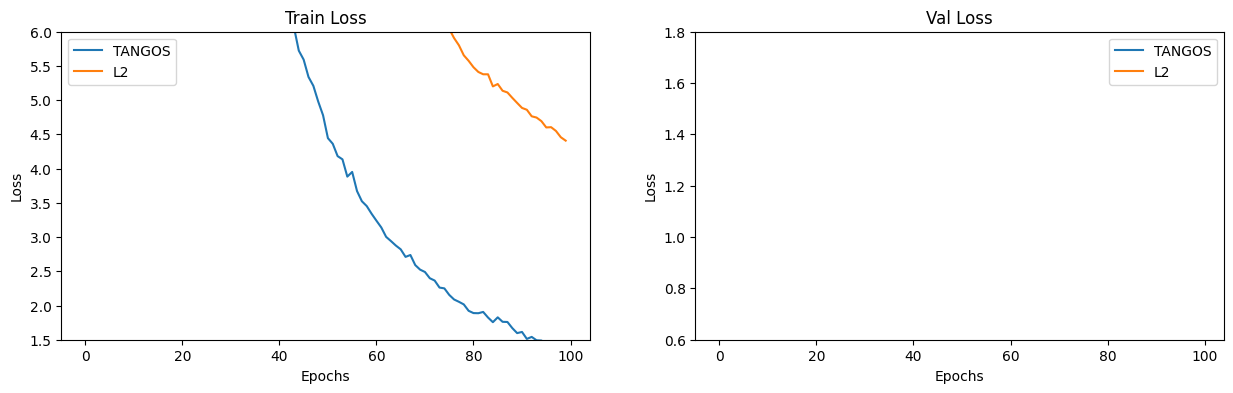

In [25]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.title("Train Loss")
plt.plot(TANGOS_train_loss_ls, label="TANGOS")
plt.plot(L2_train_loss_ls, label="L2")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(1.5, 6)
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Val Loss")
plt.plot(TANGOS_val_loss_ls, label="TANGOS")
plt.plot(L2_val_loss_ls, label="L2")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0.6, 1.8)
plt.show()